In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

Using cuda device


In [65]:
df = pd.read_csv("data/Train_Data_final.csv")
# LongTensor should start from 0, we used to define from 1 to 4, now 0 to 3
df['total cost'] = df['total cost'] - 1
display(df)

,number of rooms,security level of the community,residence space,building space,noise level,waterfront,view,air quality level,aboveground space,basement space,...,zip code_WA 98155,zip code_WA 98166,zip code_WA 98168,zip code_WA 98177,zip code_WA 98178,zip code_WA 98188,zip code_WA 98198,zip code_WA 98199,zip code_WA 98288,zip code_WA 98354
0,5,2.50,2820,67518,2.0,0,0,3,2820,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1.00,1210,9400,1.0,0,0,2,1210,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4,2.50,2200,9397,2.0,0,0,3,2200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1.50,1200,9720,1.0,0,0,4,1200,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1.75,1370,5858,1.0,0,0,3,1370,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,4,3.50,3840,85728,2.0,0,0,3,3840,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3996,5,2.00,2310,13430,1.5,0,0,4,2310,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3997,4,2.50,3360,22111,2.0,0,0,3,3360,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3998,6,2.50,2640,3680,2.0,0,0,5,1760,880,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:

train_data, val_data = train_test_split(df, test_size=0.2, random_state=42)

# Training set
train_features = torch.tensor(train_data.drop('total cost', axis=1).values, dtype=torch.float).to(device)
train_labels = torch.LongTensor(train_data['total cost'].values).to(device)

# Validation set
val_features = torch.tensor(val_data.drop('total cost', axis=1).values, dtype=torch.float).to(device)
val_labels = torch.LongTensor(val_data['total cost'].values).to(device)



# Building our NeuralNetwork

In [67]:
# MLP 
# Reference: https://blog.csdn.net/jclian91/article/details/121708431 (Multiclass classification, Iris Dataset, MLP)
# Reference: https://www.jianshu.com/p/65aed5b33cf2 (Pytorch MLP)
class NeuralNetwork(nn.Module):
    def __init__(self, features):
        super(NeuralNetwork, self).__init__()

        self.layer1 = nn.Linear(features.shape[1], 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 4)

    def forward(self, x):
        y_pred = nn.functional.relu(self.layer1(x))
        y_pred = nn.functional.relu(self.layer2(y_pred))
        y_pred = nn.functional.relu(self.layer3(y_pred))
        y_pred = self.output(y_pred)
        return y_pred


In [68]:
model = NeuralNetwork(train_features).to(device)
print(model)

NeuralNetwork(
  (layer1): Linear(in_features=136, out_features=256, bias=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=4, bias=True)
)


In [69]:
# Define Loss Fuction
loss_fn = nn.CrossEntropyLoss()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [70]:
# Curves list
losses_train = []
losses_val = []
accuracies_train = []
accuracies_val = []

epochs = []
correct_train = 0
total_train = 0
correct_val = 0
total_val = 0

# hyperparameter
num_epochs = 10000

for epoch in range(num_epochs):
    # Train the model
    model.train()
    y_pred_train = model(train_features)
    loss_train = loss_fn(y_pred_train, train_labels)
    losses_train.append(loss_train.item())
    epochs.append(epoch + 1)

    # Backpropagation
    optimizer.zero_grad()
    loss_train.backward()
    optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    with torch.no_grad():
        y_pred_val = model(val_features)
        loss_val = loss_fn(y_pred_val, val_labels)
        losses_val.append(loss_val.item())


    # Reference: https://stackoverflow.com/questions/51503851/calculate-the-accuracy-every-epoch-in-pytorch/63271002#63271002
    # Calculate accuracy on validation set
    _, predicted_val = torch.max(y_pred_val, 1)
    correct_val += (predicted_val == val_labels).sum().item()
    total_val += val_labels.size(0)
    accuracy_val = correct_val / total_val * 100

    
    # Calculate accuracy on training set
    _, predicted_train = torch.max(y_pred_train, 1)
    correct_train += (predicted_train == train_labels).sum().item()
    total_train += train_labels.size(0)
    accuracy_train = correct_train / total_train * 100
    
    accuracies_train.append(accuracy_train)
    accuracies_val.append(accuracy_val)

    # output epoch, Training Loss, Training Accuracy, Validation Loss, Validation Accuracy
    print(f"Epoch: {epoch + 1},     Training Loss: {loss_train}, Training Acc: {accuracy_train:.2f}%") 
    print(f"              Val Loss: {loss_val}, Val Acc: {accuracy_val:.2f}%")   

Epoch: 1,     Training Loss: 19.29322052001953, Training Acc: 19.69%
              Val Loss: 25.982803344726562, Val Acc: 39.75%
Epoch: 2,     Training Loss: 23.581275939941406, Training Acc: 28.59%
              Val Loss: 42.27552795410156, Val Acc: 33.31%
Epoch: 3,     Training Loss: 39.19352722167969, Training Acc: 27.48%
              Val Loss: 39.879520416259766, Val Acc: 30.33%
Epoch: 4,     Training Loss: 35.878211975097656, Training Acc: 27.15%
              Val Loss: 26.747020721435547, Val Acc: 30.38%
Epoch: 5,     Training Loss: 24.070222854614258, Training Acc: 27.73%
              Val Loss: 20.579015731811523, Val Acc: 31.62%
Epoch: 6,     Training Loss: 19.20761489868164, Training Acc: 28.98%
              Val Loss: 18.06261444091797, Val Acc: 32.27%
Epoch: 7,     Training Loss: 17.266347885131836, Training Acc: 29.62%
              Val Loss: 12.744467735290527, Val Acc: 32.62%
Epoch: 8,     Training Loss: 12.617815017700195, Training Acc: 30.03%
              Val Loss: 6

# Relationship between loss and accuracy Reference: 
# https://www.zhihu.com/question/264892967

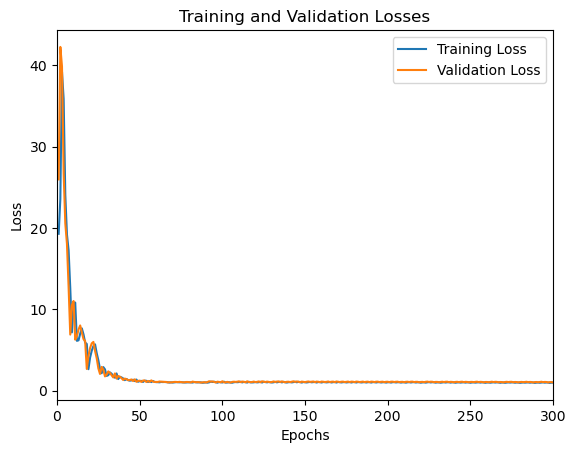

In [71]:
import matplotlib.pyplot as plt

plt.plot(epochs[:300], losses_train[:300], label="Training Loss")
plt.plot(epochs[:300], losses_val[:300], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Losses")
plt.legend()

plt.xlim(0, 300)

plt.savefig('pic/loss_' + str(num_epochs) +'.png')
plt.show()

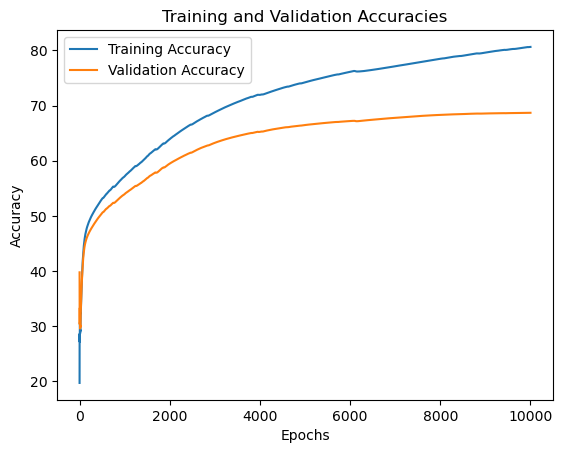

In [72]:
plt.plot(epochs, accuracies_train, label="Training Accuracy")
plt.plot(epochs, accuracies_val, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracies")
plt.legend()
plt.savefig('pic/acc_' + str(num_epochs) +'.png')
plt.show()

In [73]:
# save model
torch.save(model.state_dict(), 'model/nn_' + str(num_epochs) + '.pt')

# Prediction

In [74]:
test_data = pd.read_csv("data/Test_Data_final.csv")

test_features = torch.tensor(test_data.values, dtype=torch.float).to(device)

model.eval()

# Cancel gradient to use model
with torch.no_grad():
    y_pred_test = model(test_features)

_, predicted_labels = torch.max(y_pred_test, 1)

predicted_labels_np = predicted_labels.cpu().numpy()

raw_Test_Data = pd.read_csv("data/Test_Data.csv")

raw_Test_Data['total cost'] = predicted_labels_np + 1

raw_Test_Data.to_csv("result/prediction_" + str(num_epochs) + ".csv", index=False)
